# Circularity Measures

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import pickle
import torch
import jax
import jax.numpy as jnp
import haiku as hk
from torch.utils.data import Dataset, DataLoader
sns.set_theme()
%matplotlib inline

In [2]:
# Enable double precision data with JAX
# this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
from complex_nn.layers import Cmplx_Linear, Dropout
from complex_nn.activations import cardioid
from complex_nn.optimizers import cmplx_adam
from complex_nn.Classifier_wrapper import Haiku_Classifier
from complex_nn.utils import small_training_summary

## Circularity in complex analysis

An important characteristic of a complex random variable is the so-called `circularity` property, or
lack of it.

Circular random variables have, in fact, vanishing pseudo-variance, index that its real and imaginary parts are statistically uncorrelated. Under this perspective, a [recent work](https://arxiv.org/abs/2009.08340v2) have shown
that the circularity property of a dataset can significantly impact on the different performances, obtained using a complex-valued model with respect to its real counterpart. At least in principle, in fact, complex-valued networks seems to benefit more of dataset presenting inherent correlations. <br>
Let us denote the vector $u=[X,Y]^T$ as the real vector built by stacking the real and imaginary parts of a complex random variable $Z = X + iY$. The probability density function of $Z$ can be identified with the pdf of $u$. The variance of $Z$ is defined by:

$$
\sigma^2_Z = E[|Z - E[Z]|^2] = E[|Z|^2] - |E[Z]|^2 = \sigma_X^2 + \sigma_Y^2
$$

where $\sigma^2_X$ and $\sigma^2_Y$ are respectively the variances of $X$ and $Y$.

Also, we denote the $2x2$ real covariance matrix of $u$ by:

$$
\Sigma\triangleq E\left[\left(\begin{matrix} x\\ y\end{matrix}\right)\left(\begin{matrix} x & y\end{matrix}\right)\right] = \left(\begin{matrix}\sigma_x^2 & \sigma_{xy}\\ \sigma_{xy} & \sigma_y^2  \end{matrix}\right)
$$

However, these parameters does not bring any information about the `covariance` of $Z$:

$$
\sigma_{XY} \triangleq E[\left(X-E[X]\right)\left(Y-E[Y]\right)]
$$

for which we need to rely on another statistical quantity defined for complex random variables, i.e. the `pseudo-variance`:

$$
\tau_Z\triangleq E[\left(Z-E[Z]\right)^2] = \sigma^2_{X} - \sigma^2_Y + 2i\sigma_{XY}
$$

Unlike the variance of $Z$, which is always real and positive, the pseudo-variance is in general complex. <br>
We define the `circular quotient` $\rho_Z$ as:

$$
\rho_Z = \frac{\tau_Z}{\sigma^2_Z}
$$

Additionally, we can define also a `correlation coefficient` among real and imaginary parts of $Z$:

$$
\rho = \frac{\sigma_{XY}}{\sigma_X\sigma_Y} 
$$

In some papers, the circular quotient is defined as a covariance measure between $Z$ and $\bar{Z}$, so among a random variable and its complex conjugate, rather than considering real and imaginary parts. We believe that those formulations in the end are equivalent from a practical point of view and so they can be used interchangeably. <br>
Another interesting fact is that $\rho_Z$ possess an intuitive geometrical interpretation since the modulus and phase of its principal square-root are equal to the eccentricity and angle of orientation of the ellipse defined by the covariance matrix of the real and imaginary parts of $Z$.

## Classification of circular features

The idea behind this analysis is to understand how much complex-valued models can effectively benefit of data with good circularity properties. For this reason we will generate two distinct complex datasets, one with high correlations among real and imaginary components, and one with poor correlations.

An easy way to generate data with determined circularity is to rely on the `complex normal distribution`, that characterizes complex random variables whose real and imaginary parts are jointly normal. Differently from its real-valued counterpart, such distribution depends on three parameters:
* the _location_ $\mu$;
* the _covariance matrix_ $\Gamma$;
* the _location matrix_ $C$.

The `standard complex normal` is the univariate distribution with $\mu=0$, $\Gamma=1$ and $C=0$.

A complex random vector $Z$ is called circularly symmetric if for every $\varphi\in[-\pi,\pi)$ the distribution of $e^{i\varphi}Z$ is the same of the distribution of $Z$. The PDF then satisfies $f(z)=cg(|z|^2)$ for some non-negative function $g$ and normalizing constant $c$. Hence, the regions of constant contours are circles in the complex plane. Central normal complex random vectors that are circularly symmetric are of particular interest because they are fully specified by the covariance matrix $\Gamma$.

We can generate circular random complex data simply exploiting the `multivariate_random_normal` distribution, supported by numpy. We just need to generate 2-dimensional data, for the real and imaginary part respectively. Tuning the corresponding covariance matrix we can then regulate the two main sources of circularity:
* $\sigma_x \neq \sigma_y$
* $\sigma_{xy} \neq 0$

If a random variable $z=x+iy$ has zero-mean, it is circular complex normal if $\sim N_2(0,\sigma^2)$, i.e. $x$ and $y$ are iid real variables with variance $\sigma^2$. Thus, $\sigma_z^2=2\sigma^2$ and the pdf becomes:
$$
f(x,y|\sigma^2) = f(z|\sigma_z^2) = \frac{1}{\pi\sigma^2}exp({-|z|^2 /\sigma_z^2})
$$

In [4]:
def generate_cmplx_distribution(cov_mat, shape):
    """Generate an array of complex-valued random numbers distributed according to a zero-centered
    multivariate normal distribution, given in input the corresponding covariance matrix."""    
    return np.random.multivariate_normal(np.zeros(2), cov_mat, size=shape).view(np.complex128).squeeze()

Before going on, let's define a function that compute the empirical circularity and correlations coefficients. First it quantify how much our data are effectively correlated; second, it acts as a control instruction to check the correctnees of the sample generated.

In [5]:
def get_circularity_coeff(dataset, verbose=False):
    
    cov_mat = 0.
    
    # Compute the covariance matrix among real and imaginary parts
    # of the whole dataset
    
    for i in tqdm(range(len(dataset)), leave=False):
        cov_mat += np.cov(dataset[i][0].real.flatten(), dataset[i][0].imag.flatten()) 
        
    # The covariance matrix will have the following structure:  [[Sx**2, Sxy], [Sxy, Sy**2]]
    cov_mat = cov_mat / len(dataset)

    # Compute the variance of Z:   Sz**2 = E[ |Z - E[Z]|**2 ] = Sx**2 + Sy**2
    Sx2 = cov_mat[0,0]
    Sy2 = cov_mat[1,1]
    Sz2 = cov_mat.trace() 
    
    # Get the covariance:   Sxy = E[(X-E[X])(Y-E[Y])]
    Sxy = cov_mat[0,1]
    
    # Compute the pseudo-variance:   Tz = E[ (Z-E[Z])**2 ] = Sx**2 - Sy**2 + 2iSxy
    Tz = Sx2 - Sy2 + 2.j*Sxy
    
    # Compute the circularity quotient:  rhoZ = Tz / Sz**2
    rhoZ = Tz / Sz2
    
    # Compute the correlation coefficient:  rho = Sxy / SxSy
    rho = Sxy / (np.sqrt(Sx2)*np.sqrt(Sy2))
    
    if verbose:
        return cov_mat, Sz2, Tz, rhoZ, rho
    else:
        return rhoZ, rho

Define also a Pytorch Dataset object to store such data and allow the training.

In [6]:
class NpyDataset(Dataset):
    
    def __init__(self, data, label):
        
        self.x = data
        self.y = np.full(len(data), label)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx].flatten())
        one_hot_y = torch.tensor(np.eye(2)[self.y[idx]])
        
        return (x, one_hot_y)

Let's start generating two simple __circular__ distributions. <br>
Conditions: $\sigma_x = \sigma_y$ and $\sigma_{xy}=0$.

In [ ]:
circ1 = NpyDataset(generate_cmplx_distribution(cov_mat=np.array([[1.0, 0.],[0., 1.0]]), shape=(5000,128)), label=0)
circ1_rhoz, circ1_rho = get_circularity_coeff(circ1)
print('Circularity coefficient: {:.4f}'.format(circ1_rhoz))
print('Correlation coefficient: {:.4f}'.format(circ1_rho))

circ2 = NpyDataset(generate_cmplx_distribution(cov_mat=np.array([[3.0, 0.],[0., 3.0]]), shape=(5000,128)), label=1)
circ2_rhoz, circ2_rho = get_circularity_coeff(circ2)
print('Circularity coefficient: {:.4f}'.format(circ2_rhoz))
print('Correlation coefficient: {:.4f}'.format(circ2_rho))

More specifically, we will try to distinguish a perfectly circular standard normal distribution, with the identity as covariance matrix, from another one, with different parameters.

Plot an example of such samples.

In [ ]:
sample1 = generate_cmplx_distribution(cov_mat=np.array([[1.0, 0.],[0., 1.0]]), shape=(1000,))
sample2 = generate_cmplx_distribution(cov_mat=np.array([[3.0, 0.],[0., 3.0]]), shape=(1000,))

fig, ax = plt.subplots(1,1,figsize=(8,5))
sns.scatterplot(x=sample1.real, y=sample1.imag, ax=ax, label=r'$\sigma = 1.$')
sns.scatterplot(x=sample2.real, y=sample2.imag, ax=ax, label=r'$\sigma = 3.$')

ax.set_title(r'Circular complex distributions $(\sigma_{xy}=0)$', fontsize=20)
ax.set_xlabel(r'$\Re(z)$', fontsize=18)
ax.set_ylabel(r'$\Im(z)$', fontsize=18)
ax.legend(title='Variances:', fontsize=13);

To summarize: we have generated, for each distribution, 5000 samples, each of them constituted by 128 complex values normally distributed according to some pre-determined parameters. Now its time to reorganize them for the training process.

_It is important to note that the distinction between the classes is entirely contained in the relationship between the real and imaginary parts. This means that removing, for example, the imaginary part of the dataset will result in both classes being statistically identical, and therefore, making the classification impossible._

In [ ]:
full_ds = torch.utils.data.ConcatDataset([circ1, circ2])
train_ds, test_ds = torch.utils.data.random_split(full_ds, [8000, 2000])
train_dl = DataLoader(train_ds, batch_size=320, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=320, shuffle=False)

It's time to train our network. Let's first define a complex-valued model.

In [7]:
class CVNN(hk.Module):

    def __init__(self):

        super().__init__()
        self.fc1 = Cmplx_Linear(64)
        self.fc2 = Cmplx_Linear(16)
        self.fc3 = Cmplx_Linear(2)

        self.dropout = Dropout(0.2)
        self.act = cardioid

    def __call__(self, z, is_training):
        
        z = self.act(self.fc1(z))
        z = self.dropout(z, is_training)
        z = self.act(self.fc2(z))
        z = self.fc3(z)
        
        return z

In [ ]:
complex_hc = Haiku_Classifier()
_ = complex_hc.train(n_epochs = 50,
                     model = CVNN, 
                     optimizer = cmplx_adam(step_size=1e-2),
                     train_dataloader = train_dl,
                     test_dataloader = test_dl,
                     verbose = False)

We want to compare the performances of an equivalent real-valued network with two independent channels.

In [8]:
class NN2CH(hk.Module):

    def __init__(self):

        super().__init__()
        self.real_fc1 = hk.Linear(64)
        self.real_fc2 = hk.Linear(16)
        
        self.imag_fc1 = hk.Linear(64)
        self.imag_fc2 = hk.Linear(16)
        
        self.out = hk.Linear(2)
        
        self.dropout = Dropout(0.2)
        self.act = jax.nn.relu

    def __call__(self, z, is_training):
        
        x = z.real
        y = z.imag

        x = self.act(self.real_fc1(x))
        x = self.dropout(x, is_training)
        x = self.act(self.real_fc2(x))
        
        y = self.act(self.imag_fc1(y))
        y = self.dropout(y, is_training)
        y = self.act(self.imag_fc2(y))
        
        xy = jnp.concatenate([x,y], axis=-1)
        out = self.out(xy)

        return out

In [ ]:
real2ch = Haiku_Classifier()
_ = real2ch.train(n_epochs = 50,
                  model = NN2CH, 
                  optimizer = jax.experimental.optimizers.adam(step_size=1e-2),
                  train_dataloader = train_dl,
                  test_dataloader = test_dl,
                  verbose = False)

Let's examine the final results:

In [ ]:
circular_train = pd.concat([pd.DataFrame(complex_hc.training_history), pd.DataFrame(real2ch.training_history)])
circular_train.reset_index(inplace=True)
circular_train['label'] = ['cmplx'] * 50 + ['real_2ch'] * 50

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.lineplot(x='index', y='train_loss', hue='label', data=circular_train, ax=ax[0])
sns.lineplot(x='index', y='val_loss', hue='label', data=circular_train, ax=ax[0])

sns.lineplot(x='index', y='train_acc', hue='label', data=circular_train, ax=ax[1])
sns.lineplot(x='index', y='val_acc', hue='label', data=circular_train, ax=ax[1])

As we can see, on such a simple problem, both models manage to converge, in the end, reaching very high accuracies on the test set $(>95\%)$. However, the complex-valued models seems to perform just a bit worse, looking at both the loss and accuracy behaviors across the epochs. In the end the difference among the models is quite negligible, but we will still take into account about it.

The next step is to check what happens is, instead, we try to distinguish a non-circular complex-valued distributions.

In [ ]:
noncirc_covmat_1 = np.array([[1., 0.],[0., 1.]])
noncirc_covmat_2 = np.array([[1., 0.75],[0.75, 1.]])

In [ ]:
noncirc1 = NpyDataset(generate_cmplx_distribution(cov_mat=noncirc_covmat_1, shape=(5000,128)), label=0)
noncirc1_rhoz, noncirc1_rho = get_circularity_coeff(noncirc1)
print('Circularity coefficient: {:.4f}'.format(noncirc1_rhoz))
print('Correlation coefficient: {:.4f}'.format(noncirc1_rho))

noncirc2 = NpyDataset(generate_cmplx_distribution(cov_mat=noncirc_covmat_2, shape=(5000,128)), label=1)
noncirc2_rhoz, noncirc2_rho = get_circularity_coeff(noncirc2)
print('Circularity coefficient: {:.4f}'.format(noncirc2_rhoz))
print('Correlation coefficient: {:.4f}'.format(noncirc2_rho))

In [ ]:
sample1 = generate_cmplx_distribution(cov_mat=noncirc_covmat_1, shape=(1000,))
sample2 = generate_cmplx_distribution(cov_mat=noncirc_covmat_2, shape=(1000,))

fig, ax = plt.subplots(1,1,figsize=(8,5))
sns.scatterplot(x=sample1.real, y=sample1.imag, ax=ax, label=r'$\sigma_{xy} = 0.$')
sns.scatterplot(x=sample2.real, y=sample2.imag, ax=ax, label=r'$\sigma_{xy} = 0.75$')

ax.set_title(r'Circular complex distributions $(\sigma=1.)$', fontsize=20)
ax.set_xlabel(r'$\Re(z)$', fontsize=18)
ax.set_ylabel(r'$\Im(z)$', fontsize=18)
ax.legend(title='Covariances:', fontsize=13);

In [ ]:
full_ds = torch.utils.data.ConcatDataset([noncirc1, noncirc2])
train_ds, test_ds = torch.utils.data.random_split(full_ds, [8000, 2000])
train_dl = DataLoader(train_ds, batch_size=320, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=320, shuffle=False)

In [ ]:
complex_hc_noncirc = Haiku_Classifier()
_ = complex_hc_noncirc.train(n_epochs = 50,
                             model = CVNN, 
                             optimizer = cmplx_adam(step_size=1e-2),
                             train_dataloader = train_dl,
                             test_dataloader = test_dl,
                             verbose = False)

In [ ]:
real2ch_noncirc = Haiku_Classifier()
_ = real2ch_noncirc.train(n_epochs = 50,
                          model = NN2CH, 
                          optimizer = jax.experimental.optimizers.adam(step_size=1e-2),
                          train_dataloader = train_dl,
                          test_dataloader = test_dl,
                          verbose = False)

In [ ]:
noncircular_train = pd.concat([pd.DataFrame(complex_hc_noncirc.training_history), pd.DataFrame(real2ch_noncirc.training_history)])
noncircular_train.reset_index(inplace=True)
noncircular_train['label'] = ['cmplx'] * 50 + ['real_2ch'] * 50

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.lineplot(x='index', y='train_loss', hue='label', data=noncircular_train, ax=ax[0])
sns.lineplot(x='index', y='val_loss', hue='label', data=noncircular_train, ax=ax[0])

sns.lineplot(x='index', y='train_acc', hue='label', data=noncircular_train, ax=ax[1])
sns.lineplot(x='index', y='val_acc', hue='label', data=noncircular_train, ax=ax[1])

This time the situation is completely different: the complex model manage to converge, while the real one barely overfits the training set, completely missing the correctness for the test set. <br>
If we manage to quantify this behavior, we could trace down a line over which complex models effectively outperform their real counterparts.

## Real vs Complex Models at different Circularity levels

Now we would like to make a quantitative analysis and understand when complex and real models perform better wrt to thei adversarials. We keep the previous task, fixing a distribution $A$ with label 0, made of data circularly distributed with the identity as covariance matrix. The distribuion $B$, instead, with label 1, will be gradually modified in order to stress the responses of the various networks and maybe find some regularity, some relation, with the degrees of circularity (or correlation) of the dataset. <br>
Just for remark, the dataset $A$ has:
$$
\sigma_x = \sigma_y = 1. \qquad \sigma_{xy}=0. \qquad\implies\qquad \rho_z = \rho = 0
$$

### First source of circularity: $\sigma_x = \sigma_y$

Let's examine the first source of circularity in a distribution, i.e. the same variances for real and imaginary parts. <br>
We start fixing $\sigma_x = \sigma_y = \sigma = 1.$ and we leave the covariance $\sigma_{xy}$ free to space the interval $(-1,1)$ (to keep the covariance matrix positive defined). Then:
$$
\rho_z = \frac{i\sigma_{xy}}{\sigma^2}, \qquad \rho=\frac{\sigma_{xy}}{\sigma^2} \qquad\implies\qquad |\rho_z| = |\rho|
$$

Let's try to understand what happens gradually changing the distributions.

In [9]:
# In order to simplify our work, we define a function that automatically creates two datasets, 
# one circular with the identity as covariance matrix, and the other with the parameters specified
# in input, and use them to train a real and a complex model for a 
# given number of epochs. Furthermore, it returns the final score as the average accuracy for both networks 
# for the last 10 epochs over the validation set.

def test_config(covmat, n_epochs=60):
        
    # Generate datasets
    dist1 = NpyDataset(generate_cmplx_distribution(cov_mat=np.array([[1.,0.],[0., 1.]]), shape=(5000,128)), label=0)
    #dist1_rhoz, dist1_rho = get_circularity_coeff(dist1)
    #print('Circularity coefficient first distribution: {:.4f}'.format(dist1_rhoz))
    #print('Correlation coefficient first distribution {:.4f}'.format(dist1_rho))

    dist2 = NpyDataset(generate_cmplx_distribution(cov_mat=covmat, shape=(5000,128)), label=1)
    dist2_rhoz, dist2_rho = get_circularity_coeff(dist2)
    #print('Circularity coefficient second distribution: {:.4f}'.format(dist2_rhoz))
    #print('Correlation coefficient second distribution: {:.4f}'.format(dist2_rho))
    
    full_ds = torch.utils.data.ConcatDataset([dist1, dist2])
    train_ds, test_ds = torch.utils.data.random_split(full_ds, [8000, 2000])
    train_dl = DataLoader(train_ds, batch_size=320, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=320, shuffle=False)
    
    # Train the complex model
    complex_hc = Haiku_Classifier()
    _ = complex_hc.train(n_epochs = n_epochs,
                         model = CVNN, 
                         optimizer = cmplx_adam(step_size=1e-2),
                         train_dataloader = train_dl,
                         test_dataloader = test_dl,
                         verbose = False)

    # Train the real model
    real2ch = Haiku_Classifier()
    _ = real2ch.train(n_epochs = n_epochs,
                      model = NN2CH, 
                      optimizer = jax.experimental.optimizers.adam(step_size=1e-2),
                      train_dataloader = train_dl,
                      test_dataloader = test_dl,
                      verbose = False)
    
    cmplx_score = np.mean(complex_hc.training_history['val_acc'][-10:])
    real_score = np.mean(real2ch.training_history['val_acc'][-10:])
        
    return dist2_rhoz, dist2_rho, cmplx_score, real_score

So, we will test different distributions, all having $\sigma_x=\sigma_y=1.$ and different covariances $\sigma_{xy}\in(-1,1)$, looking for some interesting behaviors. <br>
Each test will be repeated several times, with different numy seeds, in order to derive a more reliable statistics.

In [ ]:
#seeds = [2351, 521453, 23, 314, 451]
#source1_circ = {'seed':[], 'rhoz': [], 'rho': [], 'cmplx_score': [], 'real_score': []}
#cov_values = np.random.uniform(-1., 1., 7)

#for s in tqdm(seeds, leave=False, desc='Testing different seeds.'):
#    np.random.seed(s)
#    for sxy in tqdm(cov_values, leave=False, desc='Testing several covariances.'):
#        rz, r, cs, rs = test_config(np.array([[1., sxy], [sxy, 1.]]))
#        source1_circ['seed'].append(s)
#        source1_circ['rhoz'].append(rz)
#        source1_circ['rho'].append(r)
#        source1_circ['cmplx_score'].append(cs)
#        source1_circ['real_score'].append(rs)

#with open('notebook_results/source1_circ.pkl', 'wb') as f:
#    pickle.dump(source1_circ, f)

In [ ]:
with open('notebook_results/source1_circ.pkl', 'rb') as f:
    source1_circ = pickle.load(f)

We plot now the relationship among the accuracies obtained for both model with respect to the modulus of the circularity coefficient $\rho_z$ (in the end, remember that $|\rho_z|=|\rho|$).

In [ ]:
source1_circ = pd.DataFrame(source1_circ)
source1_circ['abs_rhoz'] = np.abs(source1_circ['rhoz'])

fig, ax = plt.subplots(1, 1, figsize=(8,5))

sns.scatterplot(x='abs_rhoz', y='cmplx_score', data=source1_circ, ax=ax)
sns.scatterplot(x='abs_rhoz', y='real_score', data=source1_circ, ax=ax)

I made some tests also with different initial values of $\sigma$, but the general behavior is this: the real model is, at the beginning, slightly better but after a certain point underperform (also by a significative percentage) wrt the complex model.

### Second Source of Circularity: $\sigma_{x}\neq\sigma_y$

Let's examine now the second main source of circularity in our datasets, i.e. a different variance for the real and imaginary parts. <br>
This time we start fixing $\sigma_{xy}=0$ and assuming, for simplicity, $\sigma_x=1.$ (in the end it is the shape of the distribution that matters). We leave, instead, $\sigma_y$ free to move in $(0.1, 3.)$. This time:
$$
\rho_z = \frac{\sigma_x^2-\sigma_y^2}{\sigma_x^2+\sigma_y^2} \qquad \rho=0
$$

In [ ]:
#seeds = [2351, 521453, 23, 314, 451]
#source2_circ = {'seed':[], 'rhoz': [], 'rho': [], 'cmplx_score': [], 'real_score': []}
#sy_values = np.random.uniform(0., 3., 10)

#for s in tqdm(seeds, leave=False, desc='Testing different seeds.'):
#    np.random.seed(s)
#    for sy in tqdm(sy_values, leave=False, desc='Testing several covariances.'):
#        rz, r, cs, rs = test_config(np.array([[1., 0.], [0., sy]]))
#        source2_circ['seed'].append(s)
#        source2_circ['rhoz'].append(rz)
#        source2_circ['rho'].append(r)
#        source2_circ['cmplx_score'].append(cs)
#        source2_circ['real_score'].append(rs)

#with open('notebook_results/source2_circ.pkl', 'wb') as f:
#    pickle.dump(source2_circ, f)

In [ ]:
with open('notebook_results/source2_circ.pkl', 'rb') as f:
    source2_circ = pickle.load(f)

In [ ]:
source2_circ = pd.DataFrame(source2_circ)
source2_circ['abs_rhoz'] = np.abs(source2_circ['rhoz'])

fig, ax = plt.subplots(1, 1, figsize=(8,5))

sns.scatterplot(x='abs_rhoz', y='cmplx_score', data=source2_circ, ax=ax)
sns.scatterplot(x='abs_rhoz', y='real_score', data=source2_circ, ax=ax)

### Complex vs Real networks vs the circularity coefficient $\rho_z$

We have found some interesting behaviors in the previous sections: there are some situations in which complex networks dominate and some other in which real-valued models perform better. But, is there any general law, or rule, that we can find, in order to understand which characteristics should our data have in order to guarantee nice performances of complex models? 

Let's proceed in the same way as before, fixing a distribution $A$ that is perfectly circular, again with the identity as covariance matrix, and let's try to classify its samples with the ones coming from a second distribution $B$ in which we add some non-circularity from both sources. 

Let's again, for the second distribution, fix $\sigma_x=1$ and let free the other two degrees of freedom $\sigma_y$ and $\sigma_{xy}$. Let's vary those parameter in order to space all the possible values that $\rho_z\in C$ can assume, i.e. all the points in the unitary complex circle.

In [ ]:
#final_source_circ = {'rhoz': [], 'rho': [], 'cmplx_score': [], 'real_score': []}

#with tqdm(total=30*2) as pbar:
#    for sy in np.random.normal(0., 2., 30):
#        for sxy in np.random.uniform(-sy, sy, 2):
#            # Check if the covariance matrix generated is positive-defined
#            rnd_covmat = np.array([[1., sxy],[sxy, sy**2]])
#            pbar.update(1)
#            try:
#                np.linalg.cholesky(rnd_covmat)
#            except:
#                continue
#            
#            rz, r, cs, rs = test_config( rnd_covmat )
#            final_source_circ['rhoz'].append(rz)
#            final_source_circ['rho'].append(r)
#            final_source_circ['cmplx_score'].append(cs)
#            final_source_circ['real_score'].append(rs)

In [91]:
#final_source_circ = pd.DataFrame(final_source_circ)
#final_source_circ['rhoz_x'] = final_source_circ['rhoz'].apply(lambda x: x.real)
#final_source_circ['rhoz_y'] = final_source_circ['rhoz'].apply(lambda x: x.imag)

In [95]:
#with open('notebook_results/acc_vs_rhoz.pkl', 'wb') as f:
#    pickle.dump(final_source_circ, f)

In [98]:
with open('notebook_results/acc_vs_rhoz.pkl', 'rb') as f:
    final_source_circ = pickle.load(f)

(-1.05, 1.05)

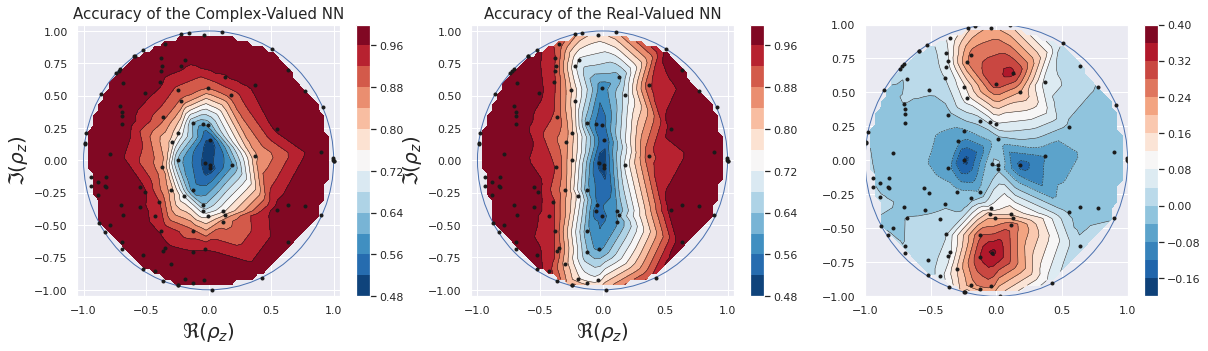

In [99]:
import matplotlib.tri as tri

fig, axs = plt.subplots(1, 3, figsize=(20,5))

# Create grid values first.
x = final_source_circ['rhoz_x']
y = final_source_circ['rhoz_y']
xi = np.linspace(-1., 1., 50)
yi = np.linspace(-1., 1., 50)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator_c = tri.LinearTriInterpolator(triang, final_source_circ['cmplx_score'])
interpolator_r = tri.LinearTriInterpolator(triang, final_source_circ['real_score'])
interpolator_cr = tri.LinearTriInterpolator(triang, final_source_circ['cmplx_score']-final_source_circ['real_score'])

Xi, Yi = np.meshgrid(xi, yi)
zi_c = interpolator_c(Xi, Yi)
zi_r = interpolator_r(Xi, Yi)
zi_cr = interpolator_cr(Xi, Yi)

axs[0].contour(xi, yi, zi_c, levels=14, linewidths=0.5, colors='k')
cntr1 = axs[0].contourf(xi, yi, zi_c, levels=14, cmap="RdBu_r")
plt.colorbar(cntr1, ax=axs[0])
axs[0].plot(x, y, 'ko', ms=3)


axs[1].contour(xi, yi, zi_r, levels=14, linewidths=0.5, colors='k')
cntr2 = axs[1].contourf(xi, yi, zi_r, levels=14, cmap="RdBu_r")
plt.colorbar(cntr2, ax=axs[1])

axs[1].plot(x, y, 'ko', ms=3)

axs[2].contour(xi, yi, zi_cr, levels=14, linewidths=0.5, colors='k')
cntr3 = axs[2].contourf(xi, yi, zi_cr, levels=14, cmap="RdBu_r")
plt.colorbar(cntr3, ax=axs[2])

axs[2].plot(x, y, 'ko', ms=3)


# Add the definition domain of rho_z, i.e. the unitary circle
unit_circle = plt.Circle((0., 0.), radius=1., edgecolor='b', facecolor='None')
axs[0].add_patch(unit_circle)
unit_circle = plt.Circle((0., 0.), radius=1., edgecolor='b', facecolor='None')
axs[1].add_patch(unit_circle)
unit_circle = plt.Circle((0., 0.), radius=1., edgecolor='b', facecolor='None')
axs[2].add_patch(unit_circle)

axs[0].set_xlabel(r'$\Re(\rho_z)$', fontsize=20)
axs[0].set_ylabel(r'$\Im(\rho_z)$', fontsize=20)
axs[0].set_title('Accuracy of the Complex-Valued NN', fontsize=15)
axs[0].set_xlim(-1.05, 1.05)
axs[0].set_ylim(-1.05, 1.05)

axs[1].set_xlabel(r'$\Re(\rho_z)$', fontsize=20)
axs[1].set_ylabel(r'$\Im(\rho_z)$', fontsize=20)
axs[1].set_title('Accuracy of the Real-Valued NN', fontsize=15)
axs[1].set_xlim(-1.05, 1.05)
axs[1].set_ylim(-1.05, 1.05)